# Check data from hubs

This notebook is intended for testing data integrity and quality. We use it for checking data from new version of the badges (hardware or firmware), and we look mainly for:
1. Gaps in the data. Thre shouldn't be gaps in the data, at least until the badge starts to reset because of low voltage
2. Battery life. We look at the voltage and see how fast it drops.

In [1]:
from __future__ import absolute_import, division, print_function

import pandas as pd
import numpy as np

import pytz
import gzip

# Import the data analysis tools
import openbadge_analysis as ob
import openbadge_analysis.preprocessing
import openbadge_analysis.core

In [2]:
# Settings
time_zone = 'US/Eastern' # Your local timezone
hublog_time_zone = 'UTC'
log_version = '2.0'
time_bins_size = '60S' # For proximity scans

folder = '../data/raw/20171205_test_proximity_missing_data/'
proximity_filename = folder+'proximity_archive.txt.gz'
audio_filename = folder+'audio_archive.txt.gz'
hublog_filename = folder+'hub.log.gz'

In [3]:
# enables the %%R magic, not necessary if you've already done this
import readline
%load_ext rpy2.ipython 

%R -i time_zone timezone <- time_zone; print(timezone)

[1] "US/Eastern"


In [17]:
%%R
library(ggplot2)
library(scales)
rh_theme = theme(
    legend.title=element_text(size=2) , 
    legend.text=element_text(size=2)
    #panel.background=element_rect(fill="white"), # background=white
    #panel.grid.major.x=element_blank(), #no gridlines
    #panel.grid.minor.x=element_blank(), 
    #panel.grid.major.y=element_blank(), 
    #panel.grid.minor.y=element_blank(),
    #axis.text.x = element_text(angle=90, hjust = 1,vjust=1,size = 4,face = "bold"),
    #axis.text.y = element_text(size = 4)
)

# Load data

In [5]:
print("Loading reset data")
with gzip.open(hublog_filename, 'r') as f:
    resets = ob.preprocessing.hublog_resets(f, log_tz = hublog_time_zone, tz=time_zone)

print("Loading voltage data (from proximity records)")
with gzip.open(proximity_filename, 'r') as f:
    voltages = ob.preprocessing.voltages(f, time_bins_size, tz=time_zone)

print("Loading record counts for proximity")
with gzip.open(proximity_filename, 'r') as f:
    proximity_counts = ob.preprocessing.record_counts(f, time_bins_size, tz=time_zone)

print("Loading record counts for audio")
with gzip.open(audio_filename, 'r') as f:
    audio_counts = ob.preprocessing.record_counts(f, time_bins_size, tz=time_zone)
    
print("Loading clock sync data")
with gzip.open(hublog_filename, 'r') as f:
    clock_syncs = ob.preprocessing.hublog_clock_syncs(f, log_tz = hublog_time_zone, tz=time_zone)

Loading reset data
Loading voltage data (from proximity records)
Loading record counts for proximity
Loading record counts for audio
Loading clock sync data


In [6]:
# starting time
first_date = resets.index.get_level_values('datetime').min()
first_date

Timestamp('2017-12-05 18:58:24.843000-0500', tz='US/Eastern')

In [7]:
def to_relative_datetime(data):
    """ switch to relative time (since experiment started) """
    realtive_time = data.reset_index().copy()
    realtive_time['datetime'] = realtive_time['datetime'] - first_date
    realtive_time['day'] = realtive_time['datetime']/pd.Timedelta(days=1)
    return realtive_time

# Cleanup
Sometimes we get some records from the future or past. It's a bug, but it's so uncommon that we haven't found the reason yet


In [38]:
time_slice = slice('2017-01-01 00:00:00', '2018-01-01 00:00:00')

resets = resets.loc[time_slice, :]
voltages = voltages.loc[time_slice, :]

proximity_counts.reset_index(level=1,inplace=True)
proximity_counts = proximity_counts.loc[time_slice, :]
proximity_counts.set_index('member', append=True, inplace=True)

audio_counts.reset_index(level=1,inplace=True)
audio_counts = audio_counts.loc[time_slice, :]
audio_counts.set_index('member', append=True, inplace=True)

clock_syncs = clock_syncs.loc[time_slice, :]

# Voltage
Here we simply show the voltages of all the badges in the test. This helps us check how long they run and how fast the battery is deplated.

In [41]:
# Down sample
voltages_down = voltages.groupby([pd.TimeGrouper('300S', level='datetime'), 'member']).mean()

In [42]:
# Relative time
voltages_realtive_time = to_relative_datetime(voltages_down)

In [43]:
print(voltages_realtive_time.dtypes)
voltages_realtive_time.head()

datetime    timedelta64[ns]
member               object
voltage             float64
day                 float64
dtype: object


datetime      member   voltage       day
0 -1 days +23:56:35.157000  UT743X7QS3  3.160000 -0.002371
1          00:01:35.157000  0MXLG3KMYX  3.145000  0.001101
2          00:01:35.157000  12MSLHS8AD  3.200000  0.001101
3          00:01:35.157000  1F11J0IMWW  3.200000  0.001101
4          00:01:35.157000  3GNN66LBQ6  3.153333  0.001101

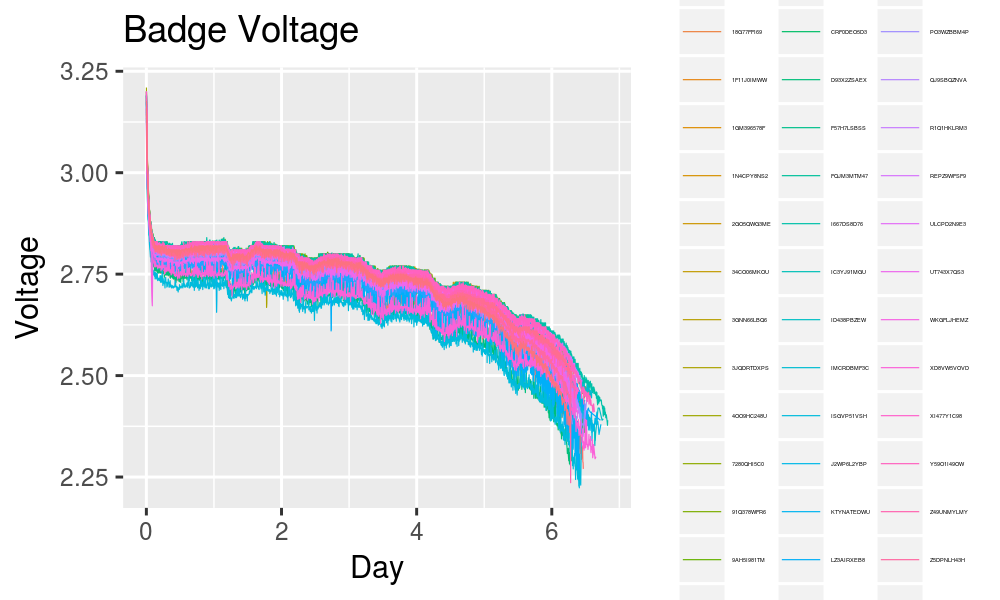

In [44]:
%%R -i voltages_realtive_time -w 5 -h 3 --units in -r 200
data <- voltages_realtive_time
#data$datetime <- as.POSIXct(data$datetime, tz = timezone)

ggplot(data, aes(x = day, y = voltage, color =member)) +
    geom_line(size=0.2) +
    labs(title="Badge Voltage", x="Day", y="Voltage") +
    rh_theme

# Resets
Here we look at "reset events" - when the hub sends the date the a badge, and the badge did not have a date set already. This means that the badge was either just turned on, or was reset. We expect to see a reset when the badge was first turned on, and we don't expect to see any resest until the voltages drop below 2.4v or so

In [45]:
resets_down = resets.copy()
resets_down['cnt'] = 1
resets_down = resets_down.groupby([pd.TimeGrouper('30min', level='datetime'), 'mac']).count()
resets_down.head(1)

cnt
datetime                  mac                   
2017-12-05 18:30:00-05:00 EC:8F:47:27:6C:DE    1

In [46]:
# switch to relative time (since experiment started)
resets_realtive_time = to_relative_datetime(resets_down)
resets_realtive_time.head()

datetime                mac  cnt       day
0 -1 days +23:31:35.157000  EC:8F:47:27:6C:DE    1 -0.019732
1          00:01:35.157000  C8:2F:80:DA:26:94    1  0.001101
2          00:01:35.157000  C8:CA:83:BE:F4:C6    1  0.001101
3          00:01:35.157000  CA:19:95:EB:DD:EF    1  0.001101
4          00:01:35.157000  CB:23:93:29:0C:B3    1  0.001101

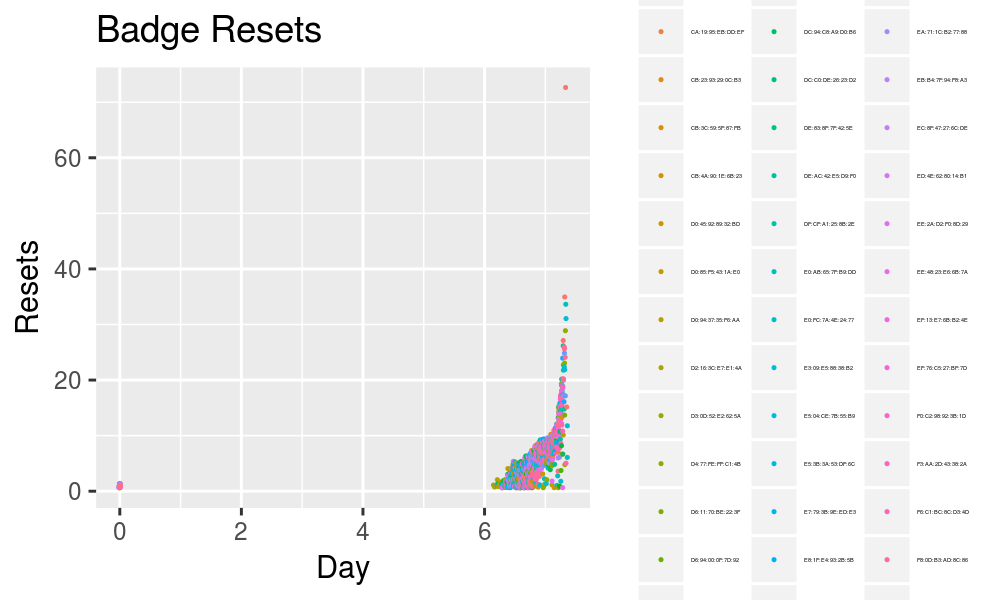

In [47]:
%%R -i resets_realtive_time -w 5 -h 3 --units in -r 200
data <- resets_realtive_time
#data$datetime <- as.POSIXct(data$datetime, tz = timezone)

ggplot(data, aes(x = day, y = cnt, color = mac)) +
    geom_point(size=0.2, position = "jitter") +
    labs(title="Badge Resets", x="Day", y="Resets") +
    rh_theme

# First resets
The first time a badge was reset (after starting)

In [76]:
df = pd.DataFrame([[1, np.nan], [1, 4], [5, 6]], columns=['A', 'B'])
g = df.groupby('A').nth(0)
df

A    B
0  1  NaN
1  1  4.0
2  5  6.0

In [81]:
first_reset = resets.copy().reset_index()
first_reset = first_reset.groupby('mac').nth(2)

In [82]:
# switch to relative time (since experiment started)
first_reset_realtive_time = to_relative_datetime(first_reset)
first_reset_realtive_time.head()

mac               datetime       day
0  C8:2F:80:DA:26:94 6 days 09:30:15.146000  6.396009
1  C8:CA:83:BE:F4:C6 6 days 12:57:10.930000  6.539710
2  CA:19:95:EB:DD:EF 6 days 10:38:50.477000  6.443640
3  CB:23:93:29:0C:B3 6 days 11:34:08.152000  6.482039
4  CB:3C:59:5F:87:FB 6 days 09:08:58.671000  6.381235

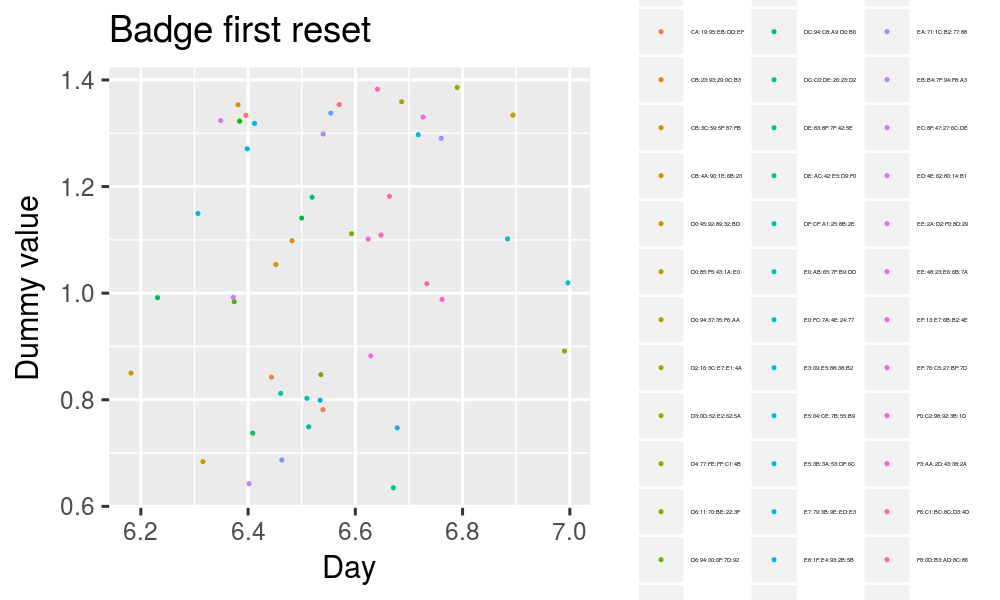

In [84]:
%%R -i first_reset_realtive_time -w 5 -h 3 --units in -r 200
data <- first_reset_realtive_time
#data$datetime <- as.POSIXct(data$datetime, tz = timezone)

ggplot(data, aes(x = day, y = 1, color = mac)) +
    geom_point(size=0.2, position = "jitter") +
    labs(title="Badge first reset", x="Day", y="Dummy value") +
    rh_theme

# Proximity record counts

In [48]:
# Down sample
proximity_counts_down = proximity_counts.copy()
proximity_counts_down = proximity_counts_down.groupby([pd.TimeGrouper('30min', level='datetime'), 'member']).mean()
proximity_counts_down.head(1)

# switch to relative time (since experiment started)
proximity_counts_realtive_time = to_relative_datetime(proximity_counts_down)
proximity_counts_realtive_time.head()

datetime      member   cnt       day
0 -1 days +23:31:35.157000  UT743X7QS3   3.0 -0.019732
1          00:01:35.157000  0MXLG3KMYX  29.0  0.001101
2          00:01:35.157000  12MSLHS8AD  29.0  0.001101
3          00:01:35.157000  18G77FFI69  29.0  0.001101
4          00:01:35.157000  1F11J0IMWW  29.0  0.001101

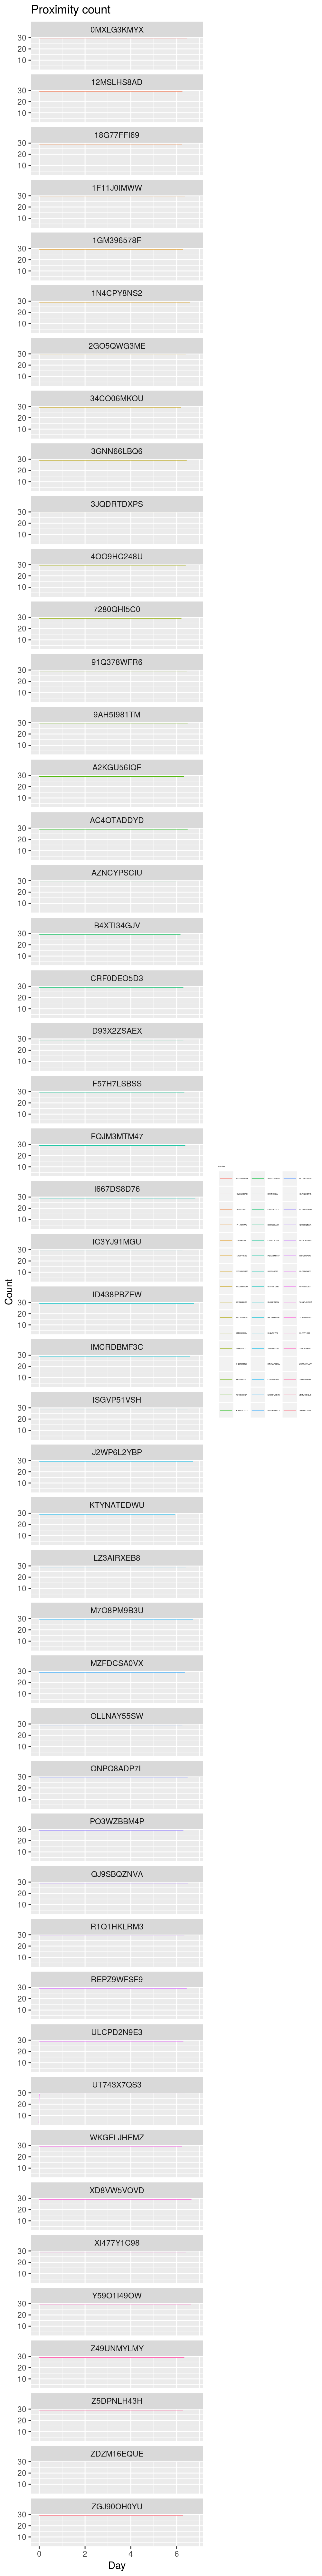

In [51]:
%%R -i proximity_counts_realtive_time -w 5 -h 40 --units in -r 200
data <- proximity_counts_realtive_time
#data$datetime <- as.POSIXct(data$datetime, tz = timezone)

ggplot(data, aes(x = day, y = cnt, color =member)) +
    geom_line(size=0.2) +
    facet_wrap( ~ member, ncol=1)+
    labs(title="Proximity count", x="Day", y="Count") +
    rh_theme

# Audio records count
For audio, we can't simply down sample. At least for the current version, we might get a "partial" record (less than 114 samples), and later the full version of the record. We'll therefore remove the duplications (using group by), and then resample and fill NaN with zeros in order to find gaps. We use a 10S window since every record represents 5.7 seconds of data, and we want to make sure not to create zero counts when there is no need to.

In [52]:
audio_counts_down = audio_counts.copy()

In [53]:
# Removing records so I can test what happens when there is missing data
#s = slice('2017-12-02 16:55:20', '2017-12-02 16:55:40')
#audio_counts_down.drop(audio_counts_down.loc[(s, slice(None), slice(None)), :].index, inplace=True)
#print(len(audio_counts))
#print(len(audio_counts_down))

In [54]:
# If there are duplicates, choose the record with the most samples (that's a complete record)
audio_counts_down = audio_counts_down.groupby(['datetime', 'member']).max()

# Put 0's if there is missing data
audio_counts_down = audio_counts_down.unstack(level=[1]).resample('10S').min().fillna(0).stack(level=[1])

In [55]:
# If removed records for testing, are there 0's there now?
#audio_counts_down.loc[(s, slice(None), slice(None)), :]

In [56]:
# Down sample
audio_counts_down = audio_counts_down.unstack(level=[1]).resample('1min').min().stack(level=[1])
audio_counts_realtive_time = audio_counts_down.reset_index()

/home/orenled/anaconda2/lib/python2.7/site-packages/rpy2/robjects/pandas2ri.py:57: UserWarning: Error while trying to convert the column "datetime". Fall back to string conversion. The error is: Cannot pass numpy arrays with non-native byte orders at the moment.
  (name, str(e)))


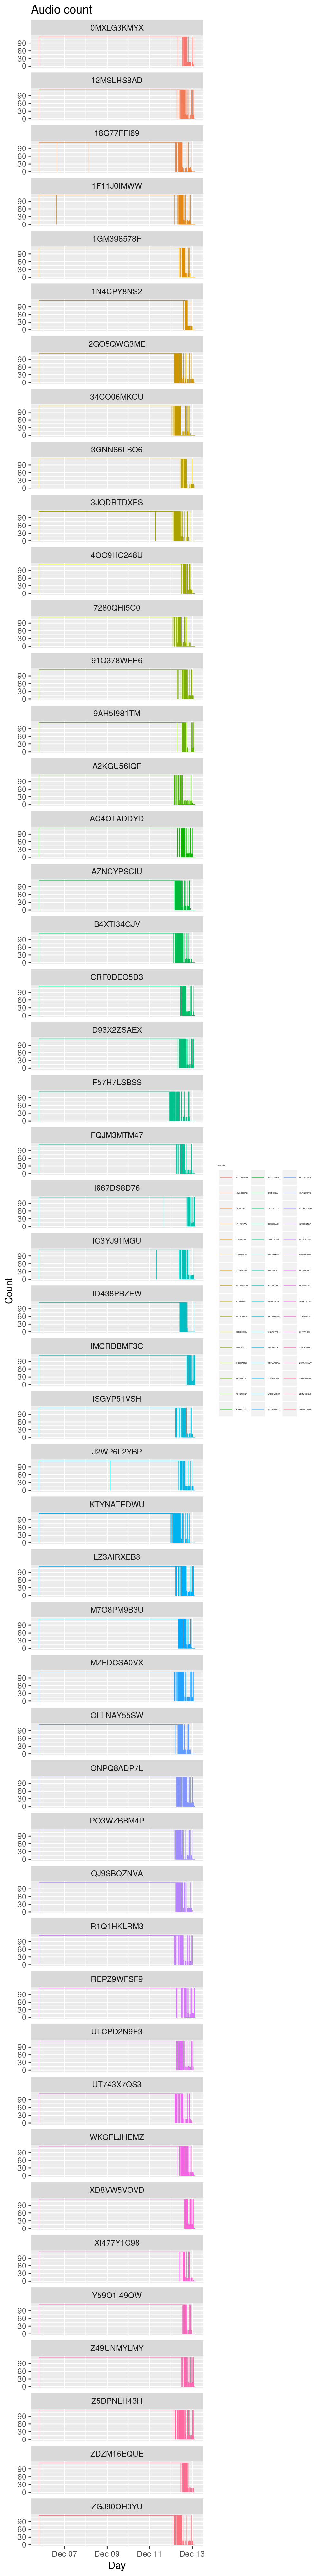

In [57]:
%%R -i audio_counts_realtive_time -w 5 -h 40 --units in -r 200
data <- audio_counts_realtive_time
data$datetime <- as.POSIXct(data$datetime, tz = timezone)

ggplot(data, aes(x = datetime, y = cnt, color = member)) +
    geom_line(size=0.2) +
    facet_wrap( ~ member, ncol=1)+
    labs(title="Audio count", x="Day", y="Count") +
    rh_theme

# Gaps in proximity data
Here we look for gaps in proximity data. We expect to see gaps of 60 seconds between scans (or less/more, depending on the settings used). If it's higher than that, then there's a gap.

In [58]:
proximity_counts_shift = proximity_counts.copy().reset_index()
proximity_counts_shift['lag_datetime'] = proximity_counts_shift.groupby(['member'])['datetime'].shift(1)
proximity_counts_shift['lag_datetime'] = proximity_counts_shift['lag_datetime'].dt.tz_localize('UTC').dt.tz_convert(time_zone)
proximity_counts_shift['time_diff_sec']= (proximity_counts_shift['datetime']-proximity_counts_shift['lag_datetime']) / np.timedelta64(1, 's')

In [59]:
proximity_counts_shift.head(5)

datetime      member  cnt              lag_datetime  \
0 2017-12-05 18:59:24-05:00  UT743X7QS3    3                       NaT   
1 2017-12-05 19:00:24-05:00  UT743X7QS3    3 2017-12-05 18:59:24-05:00   
2 2017-12-05 19:01:24-05:00  UT743X7QS3   15 2017-12-05 19:00:24-05:00   
3 2017-12-05 19:02:26-05:00  J2WP6L2YBP   29                       NaT   
4 2017-12-05 19:02:39-05:00  REPZ9WFSF9   29                       NaT   

   time_diff_sec  
0            NaN  
1           60.0  
2           60.0  
3            NaN  
4            NaN

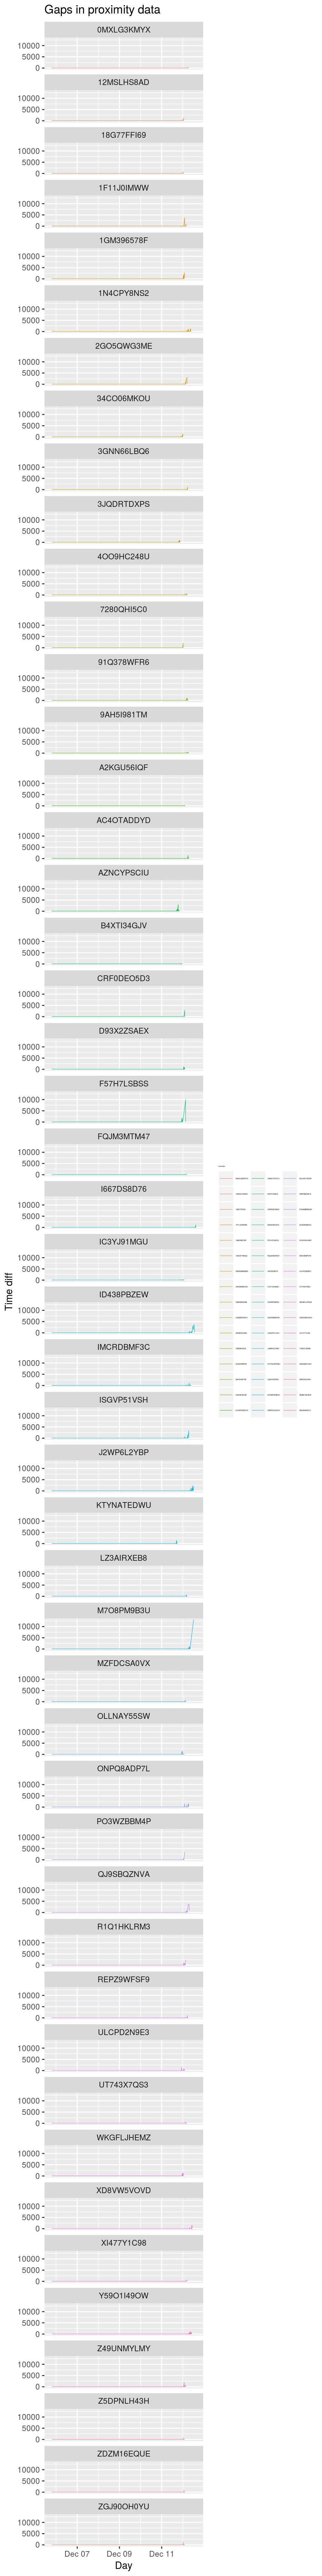

In [61]:
%%R -i proximity_counts_shift -w 5 -h 40 --units in -r 200
data <- proximity_counts_shift
data$datetime <- as.POSIXct(data$datetime, tz = timezone)

ggplot(data, aes(x = datetime, y = time_diff_sec, color = member)) +
    geom_line(size=0.2) +
    facet_wrap( ~ member, ncol=1)+
    labs(title="Gaps in proximity data", x="Day", y="Time diff") +
    rh_theme

# Gaps in audio data
Here we look for gaps in audio data. We expect to see gaps of 5.7 seconds between records (each record represents 114 samples of 50 ms each). If it's higher than that, then there's a gap.

In [62]:
audio_counts_shift = audio_counts.copy().reset_index()
audio_counts_shift['lag_datetime'] = audio_counts_shift.groupby(['member'])['datetime'].shift(1)
audio_counts_shift['lag_datetime'] = audio_counts_shift['lag_datetime'].dt.tz_localize('UTC').dt.tz_convert(time_zone)
audio_counts_shift['time_diff_sec']= (audio_counts_shift['datetime']-audio_counts_shift['lag_datetime']) / np.timedelta64(1, 's')

In [63]:
audio_counts_shift.head(5)

datetime      member  cnt  \
0 2017-12-05 18:58:24.806000-05:00  UT743X7QS3    1   
1 2017-12-05 18:58:24.806000-05:00  UT743X7QS3  114   
2 2017-12-05 18:58:30.507000-05:00  UT743X7QS3   62   
3 2017-12-05 18:58:30.507000-05:00  UT743X7QS3  114   
4 2017-12-05 18:58:36.205000-05:00  UT743X7QS3  114   

                      lag_datetime  time_diff_sec  
0                              NaT            NaN  
1 2017-12-05 18:58:24.806000-05:00          0.000  
2 2017-12-05 18:58:24.806000-05:00          5.701  
3 2017-12-05 18:58:30.507000-05:00          0.000  
4 2017-12-05 18:58:30.507000-05:00          5.698

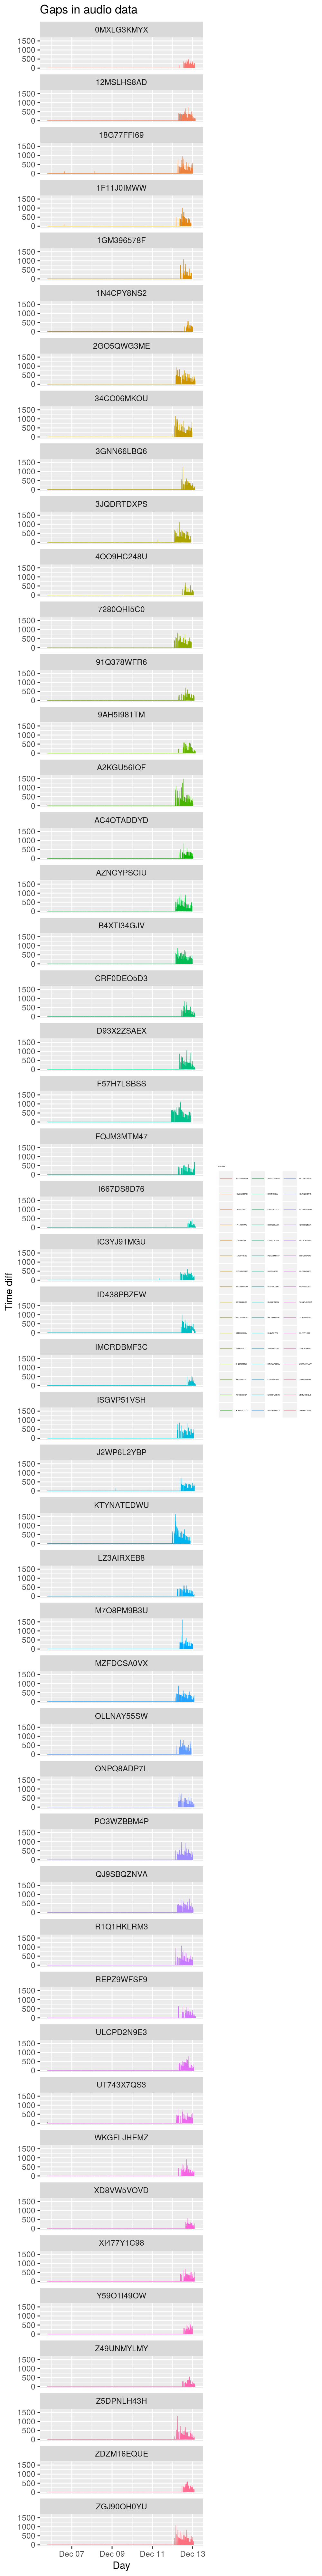

In [65]:
%%R -i audio_counts_shift -w 5 -h 40 --units in -r 200
data <- audio_counts_shift
data$datetime <- as.POSIXct(data$datetime, tz = timezone)

ggplot(data, aes(x = datetime, y = time_diff_sec, color = member)) +
    geom_line(size=0.2) +
    facet_wrap( ~ member, ncol=1)+
    labs(title="Gaps in audio data", x="Day", y="Time diff") +
    rh_theme

# Comparing badge time to hub time
Here, we look at event where we send time from the hub to the badge. On each event, the badge reports back its internal time

In [66]:
clock_syncs.head()

mac  \
datetime                                              
2017-12-05 18:58:24.886000-05:00  EC:8F:47:27:6C:DE   
2017-12-05 18:58:33.550000-05:00  EC:8F:47:27:6C:DE   
2017-12-05 18:58:33.592000-05:00  EC:8F:47:27:6C:DE   
2017-12-05 18:58:41.867000-05:00  EC:8F:47:27:6C:DE   
2017-12-05 18:58:41.910000-05:00  EC:8F:47:27:6C:DE   

                                                   badge_datetime  
datetime                                                           
2017-12-05 18:58:24.886000-05:00 2017-12-05 18:58:24.846000-05:00  
2017-12-05 18:58:33.550000-05:00 2017-12-05 18:58:33.511000-05:00  
2017-12-05 18:58:33.592000-05:00 2017-12-05 18:58:33.551000-05:00  
2017-12-05 18:58:41.867000-05:00 2017-12-05 18:58:41.828000-05:00  
2017-12-05 18:58:41.910000-05:00 2017-12-05 18:58:41.870000-05:00

In [67]:
# Down sample
clock_syncs_down = clock_syncs.copy().reset_index()
clock_syncs_down['clock_diff']=(clock_syncs_down['datetime']-clock_syncs_down['badge_datetime'])/pd.Timedelta(milliseconds=1)

clock_syncs_down.set_index(['datetime','mac'], inplace=True)
clock_syncs_down = clock_syncs_down.groupby([pd.TimeGrouper('30min', level='datetime'), 'mac'])['clock_diff'].max().to_frame()
clock_syncs_down.reset_index(inplace=True)

In [68]:
clock_syncs_down.head(5)

datetime                mac  clock_diff
0 2017-12-05 18:30:00-05:00  EC:8F:47:27:6C:DE        42.0
1 2017-12-05 19:00:00-05:00  C8:2F:80:DA:26:94       111.0
2 2017-12-05 19:00:00-05:00  C8:CA:83:BE:F4:C6        82.0
3 2017-12-05 19:00:00-05:00  CA:19:95:EB:DD:EF       101.0
4 2017-12-05 19:00:00-05:00  CB:23:93:29:0C:B3        63.0

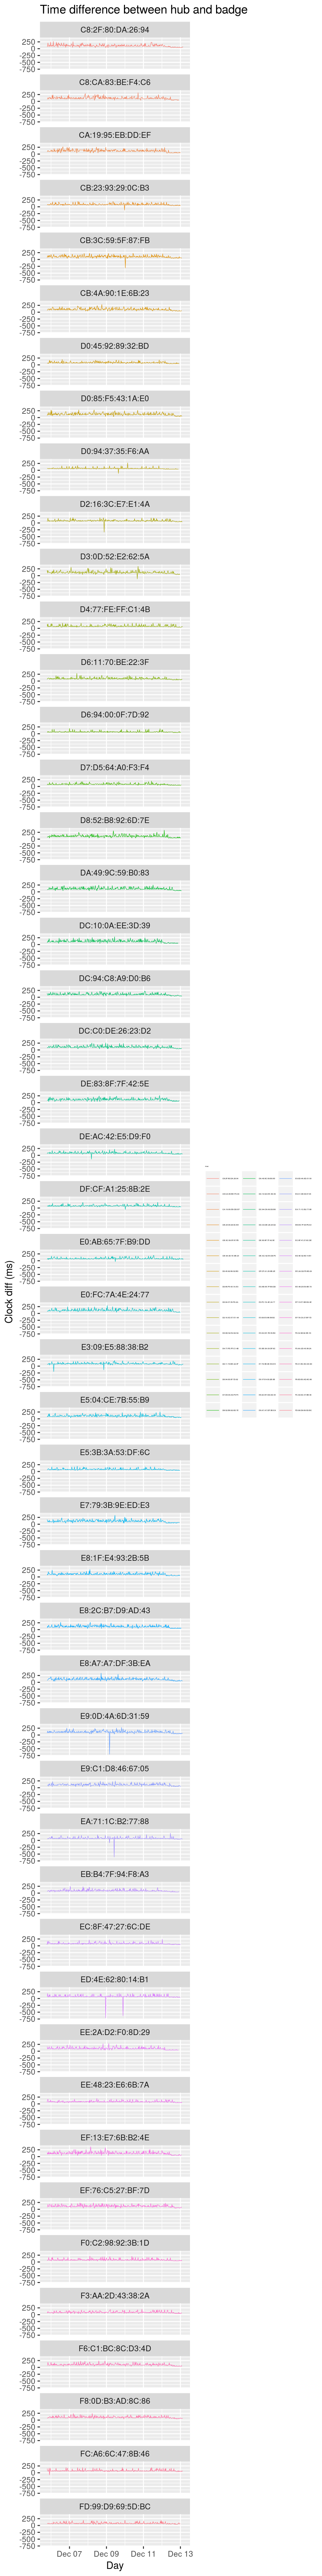

In [69]:
%%R -i clock_syncs_down -w 5 -h 40 --units in -r 200
data <- clock_syncs_down
data$datetime <- as.POSIXct(data$datetime, tz = timezone)

ggplot(data, aes(x = datetime, y = clock_diff, color = mac)) +
    geom_line(size=0.2) +
    facet_wrap( ~ mac, ncol=1)+
    labs(title="Time difference between hub and badge", x="Day", y="Clock diff (ms)") +
    rh_theme